For each metabolite in the synthetic G2/G3 redox network, find the path to the nearest KEGG metabolite: 

In [5]:
import pandas as pd
import os
import networkx as nx
import sys

sys.path.append('..')
# from Network_Path_Analysis_Tools import *
import numpy as np
# molecule visualization stuff: 
from IPython.display import Image, SVG, display
from rdkit.Chem import AllChem,Draw,Descriptors
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def to_network_format(rxn_network_file, metabolites, df_rxn):

    with open(rxn_network_file, 'w') as out_file:
    # For each unique metabolite in the reaction list 
        for met in metabolites:
            # find all reaction with that metabolite as a *substrate*
            df_temp = df_rxn[ (df_rxn.subs == met)]
            # Get all products for those reactions. 
            met_prods = list(df_temp.prods.values)
            # concatenate them into a single line
            rxn_file_line = '\t'.join([met]+ met_prods)
            out_file.write(rxn_file_line + '\n')

In [7]:
def add_KEGG_seed(row, KEGG_neighbors_dict, df_cutoff):
    if pd.isnull(row.KEGG_IDs):
        try:
            kegg_seed_sm = KEGG_neighbors_dict[row.smiles][0] 
            kegg_seed_ID = df_cutoff[df_cutoff.smiles == kegg_seed_sm].KEGG_IDs.values[0]
            return kegg_seed_ID
        except:
            return None
    
def add_path_to_seed(row, KEGG_neighbors_dict, df_cutoff):
    if pd.isnull(row.KEGG_IDs):
        try:
            path = KEGG_neighbors_dict[row.smiles][1] 
            return '>>'.join(path)
        except:
            return None

In [8]:
def add_subs_col(row):
    return row.rxn.split('>>')[0]
def add_prods_col(row):
    return row.rxn.split('>>')[1]

# Load reaction set: 

In [9]:
file_6C_red = 'data_for_Ben/6C_G2G3_redox.csv'
df_6C_red = pd.read_csv(file_6C_red)

add subs and prods columns: 

In [10]:
df_6C_red['subs'] = df_6C_red.apply(add_subs_col, 1)
df_6C_red['prods'] = df_6C_red.apply(add_prods_col, 1)

In [11]:
df_6C_red.head()

,rxn,subs,prods
0,CC=O>>CCO,CC=O,CCO
1,CC=O>>CCN,CC=O,CCN
2,O=CCO>>OCCO,O=CCO,OCCO
3,O=CCO>>NCCO,O=CCO,NCCO
4,NCC=O>>NCCN,NCC=O,NCCN


Save to file: 

In [12]:
df_6C_red.to_csv('data_for_Ben/6C_G2G3_redox_w_sub_prod.csv', index=False)

Get unique metabolites: 

In [13]:
subs = [rxn.split('>>')[0] for rxn in df_6C_red.rxn.values]
prods = [rxn.split('>>')[1] for rxn in df_6C_red.rxn.values]
metabolites = list(set(subs+prods))
len(metabolites)

2567

Create dataframe with all unique molecules in KEGG-derived network:

In [14]:
df_6C_red_mols = pd.DataFrame(columns=(['smiles']))

df_6C_red_mols['smiles'] = metabolites

# Load KEGG smiles: 

Grab all molecules in KEGG with <= numC carbon atoms: 

In [15]:
df_kegg = pd.read_csv('KID_smiles_numC_name.csv')
numC = 6
df_cutoff = df_kegg[df_kegg.numC <= numC]
df_cutoff = df_cutoff.sort_values('KEGG_IDs')

df_cutoff = df_cutoff.drop_duplicates('smiles')
smiles_cutoff = df_cutoff.smiles.values


categorize KEGG and non-KEGG metabolites in network: 

In [16]:
metabolites_KEGG = [m for m in metabolites if m in smiles_cutoff ]
metabolites_nonKEGG = [m for m in metabolites if m not in smiles_cutoff ]

In [17]:
print len(metabolites_nonKEGG)
print len(metabolites_KEGG)

1697
870


# Convert reaction network to networkX format: 

In [15]:
net_file = 'data_for_Ben/6C_KEGG_red_net.txt'
to_network_format(net_file, metabolites, df_6C_red)

Read in with networkX

In [18]:
net_file = 'data_for_Ben/6C_KEGG_red_net.txt'
G_6C_red = nx.read_adjlist(net_file, delimiter = '\t', 
                        create_using=nx.Graph())

# Shortest path analysis: 

In [20]:
KEGG_neighbors_dict = {}
# for each non-KEGG (non-natural metabolite in the network)
for target in metabolites_nonKEGG:
# target = metabolites_nonKEGG[100]
    path_len_dict = {}
    # find paths to each natural / KEGG metabolite in Network. 
    for source in metabolites_KEGG:
        if nx.has_path(G_6C_red, source, target):
            path_len_dict[source] = nx.shortest_path(G_6C_red, source, target)
        # select shortest path: 
    if len(path_len_dict.values()):
        min_len = np.min([len(x) for x in path_len_dict.values()])
        min_path = [(key, val) for key, val in path_len_dict.items() if len(val) == min_len][0]
    #find shortest path: 
        KEGG_neighbors_dict[target] = min_path


Merge with KEGG database (KID, names, etc. )

In [21]:
df_6C_red_mols_w_KEGG = pd.merge(df_6C_red_mols, df_cutoff, on='smiles', how='left')

For each non-KEGG metabolite in KEGG-derived network, find the KEGG seed it originates from and the path that takes you there: 

In [22]:
df_6C_red_mols_w_KEGG['seed'] = df_6C_red_mols_w_KEGG.apply(add_KEGG_seed, 1, 
                                                            args=[KEGG_neighbors_dict, df_cutoff])
df_6C_red_mols_w_KEGG['path'] = df_6C_red_mols_w_KEGG.apply(add_path_to_seed, 1, 
                                                            args=[KEGG_neighbors_dict, df_cutoff])


In [23]:
df_6C_red_mols_w_KEGG.head(2)

,smiles,KEGG_IDs,numC,name,seed,path
0,O=CC(O)C(=O)C(O)(C=O)C(=O)O,NaN,NaN,NaN,C03215,O=C(O)[C@@](O)(CO)[C@H](O)[C@H](O)CO>>O=C(O)C(...
1,NC1C(=O)C(=O)C(=O)C(N)C1O,NaN,NaN,NaN,C01854,N[C@H]1[C@H](O)[C@@H](N)[C@H](O)[C@@H](O)[C@@H...


# For a given metabolite in KEGG-derived network, visualize that path from a KEGG metabolite that gets you there: 

In [24]:
df_kegg.head(2)

,KEGG_IDs,smiles,numC,name
0,C01563,NC(=O)O,1,Carbamate
1,C00086,NC(N)=O,1,Urea


In [25]:
def vis_path(smiles, df_6C_red_mols_w_KEGG, df_cutoff, df_kegg):
    df_temp = df_6C_red_mols_w_KEGG[df_6C_red_mols_w_KEGG.smiles == smiles]
    kegg_seed = df_temp.seed.values[0]
    name = df_cutoff[df_cutoff.KEGG_IDs == kegg_seed].name.values[0]
    kegg_seed_smiles = df_kegg[df_kegg.KEGG_IDs==kegg_seed].smiles.values[0]
    path_temp = df_temp.path.values[0]
    
    print '---------------'
    print 'Desired non-natural product:'
    display(AllChem.MolFromSmiles(smiles))
    print 'The originating KEGG seed:'
    print kegg_seed
    print name
    display(AllChem.MolFromSmiles(kegg_seed_smiles))
    for i in range(len(path_temp.split('>>'))-1):   
        path_temp_temp = '>>'.join(path_temp.split('>>')[i:i+2])
        display(AllChem.ReactionFromSmarts(str(path_temp_temp)))

In [ ]:
#aldehydes
G2_ald = AllChem.ReactionFromSmarts('[CX3H1:2](=O)[#6:1] >>[#6:1][CX4H2:2][OX2H1]')
#Ketones
G2_ket = AllChem.ReactionFromSmarts('[#6:1][CX3:2](=O)[#6:3] >>[#6:1][CX4H1:2]([#6:3])[OX2H1]')

---------------
Desired non-natural product:


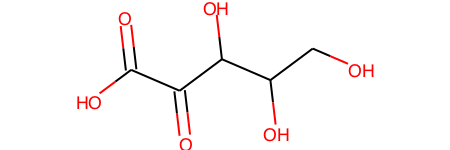

The originating KEGG seed:
C00878
D-Arabinonate


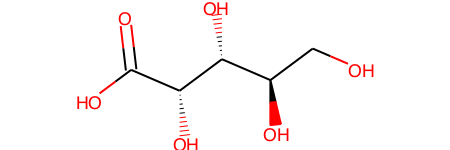

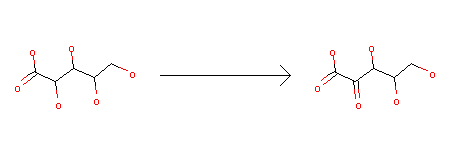

---------------
Desired non-natural product:


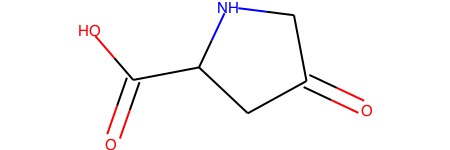

The originating KEGG seed:
C01015
cis-4-Hydroxy-L-proline


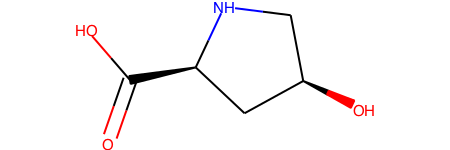

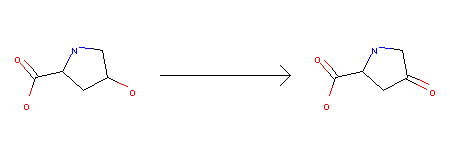

---------------
Desired non-natural product:


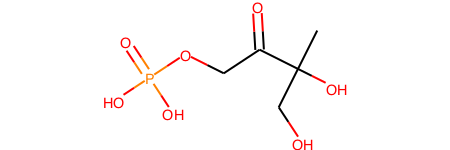

The originating KEGG seed:
C11434
2-C-Methyl-D-erythritol 4-phosphate


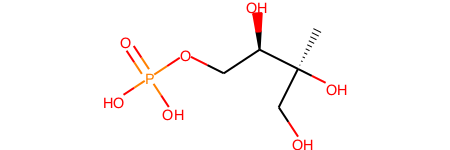

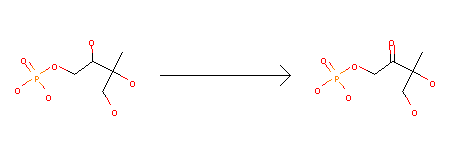

---------------
Desired non-natural product:


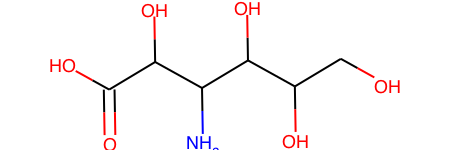

The originating KEGG seed:
C00618
3-Dehydro-L-gulonate


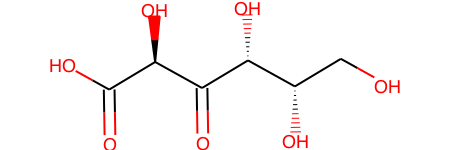

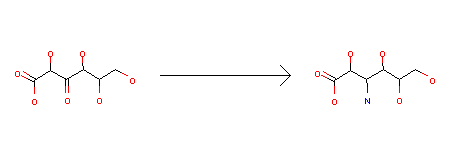

---------------
Desired non-natural product:


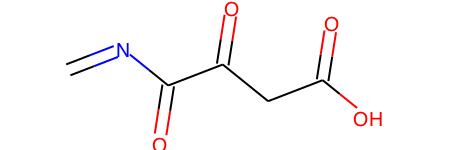

The originating KEGG seed:
C05133
4-Imidazolone-5-acetate


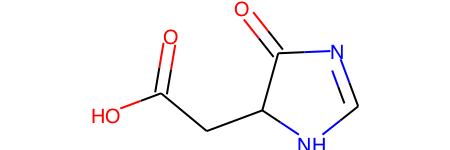

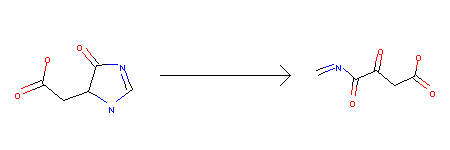

---------------
Desired non-natural product:


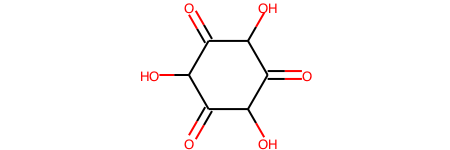

The originating KEGG seed:
C20251
1-Keto-D-chiro-inositol


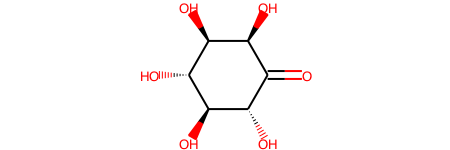

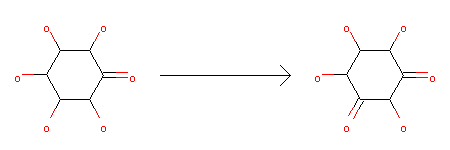

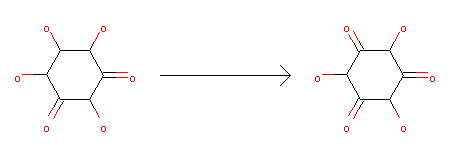

---------------
Desired non-natural product:


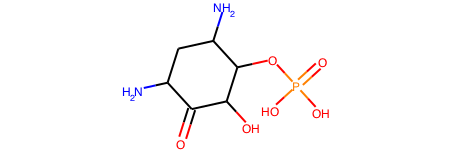

The originating KEGG seed:
C03980
2-Deoxystreptamine 4-phosphate


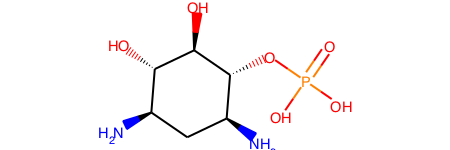

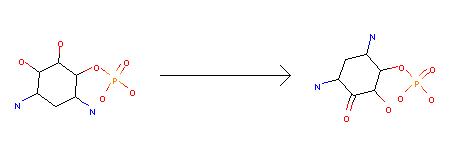

---------------
Desired non-natural product:


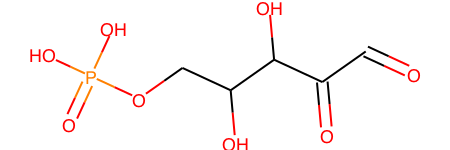

The originating KEGG seed:
C00231
D-Xylulose 5-phosphate


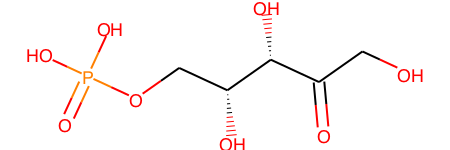

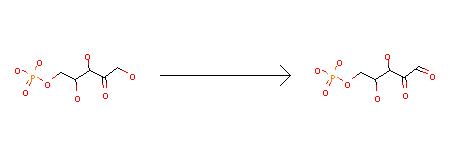

---------------
Desired non-natural product:


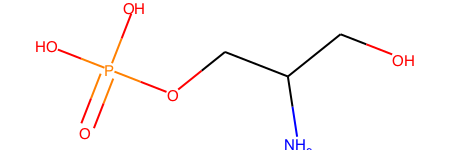

The originating KEGG seed:
C00111
Glycerone phosphate


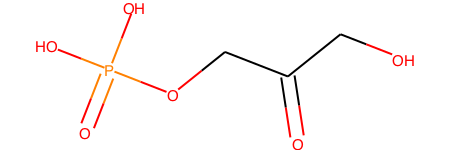

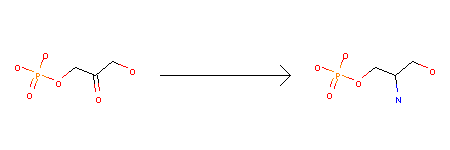

---------------
Desired non-natural product:


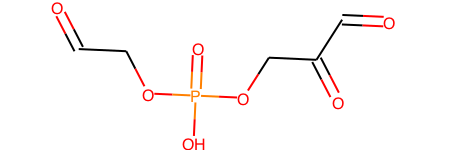

The originating KEGG seed:
C01233
sn-Glycero-3-phosphoethanolamine


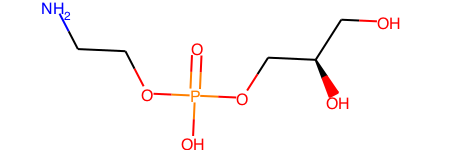

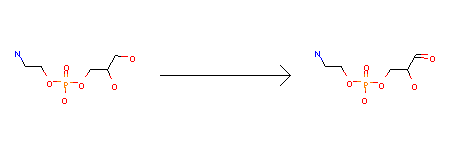

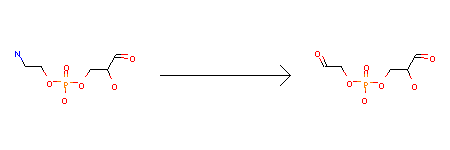

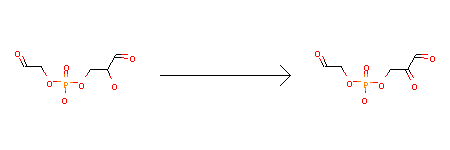

---------------
Desired non-natural product:


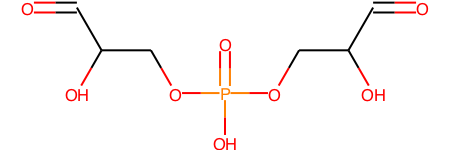

The originating KEGG seed:
C03274
Glycerophosphoglycerol


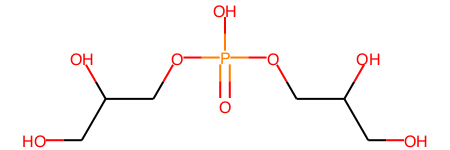

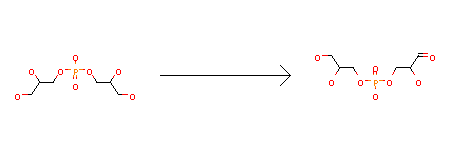

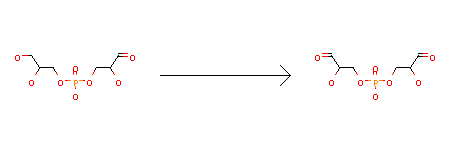

---------------
Desired non-natural product:


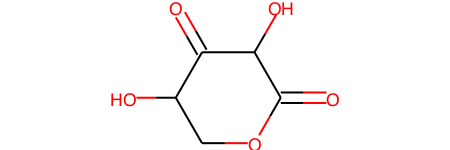

The originating KEGG seed:
C05405
L-Arabinono-1,5-lactone


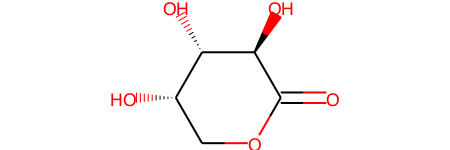

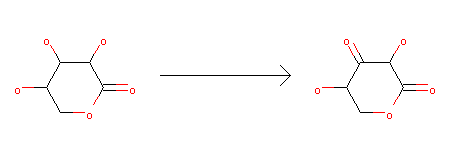

---------------
Desired non-natural product:


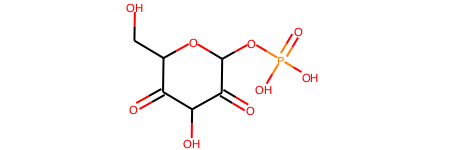

The originating KEGG seed:
C00446
alpha-D-Galactose 1-phosphate


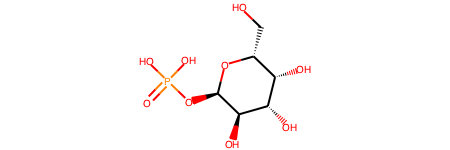

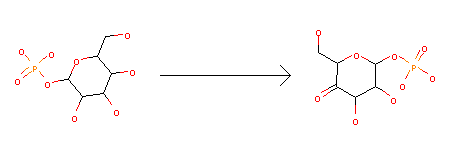

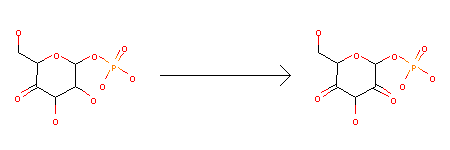

---------------
Desired non-natural product:


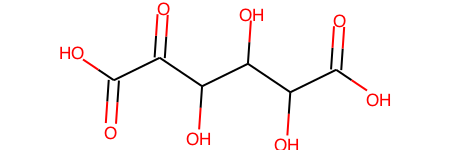

The originating KEGG seed:
C00879
D-Galactarate


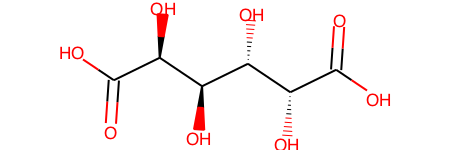

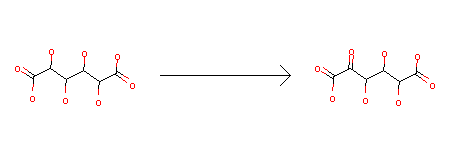

---------------
Desired non-natural product:


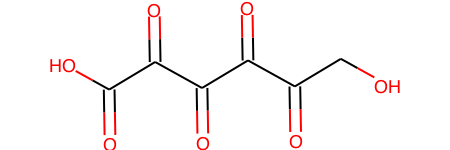

The originating KEGG seed:
C04575
(4R,5S)-4,5,6-Trihydroxy-2,3-dioxohexanoate


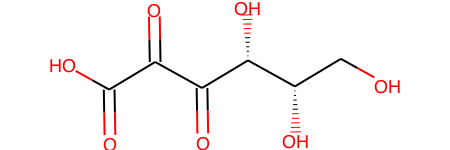

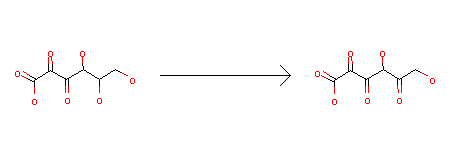

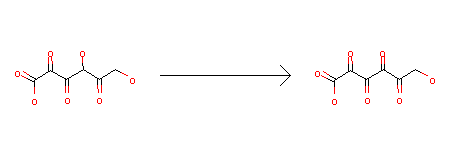

In [26]:
for sm_temp in np.random.choice(metabolites_nonKEGG, 15):
    vis_path(sm_temp, df_6C_red_mols_w_KEGG, df_cutoff, df_kegg)